# Analysis - Stagewise Comparisons
Notebook for stagewise analysis of data, comparing different stages of development. Plan is to take 3 different approaches:
1. Compare samples surrounding birth
2. Compare samples surrounding eye-opening
3. Compare samples grouped using our 'unsupervised' approach from the hierarchical clustering in the agewise notebook

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import qc_metrics as qc
import anndata2ri
import rpy2
import os
import seaborn as sns
import statistics as stats
import math
FIG_PATH = '/group/ll005/cmcphan/notebooks/analysis/results/figures/'

anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_1433102/820289153.py:14: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
herring = ad.read_h5ad('/group/ll005/cmcphan/herring_data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad')
sepp_human = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal_reduced.h5ad')
sepp_mouse = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse_normal_reduced.h5ad')
sepp_opossum = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum_normal_reduced.h5ad')

In [3]:
herring.obs[['stage_id', 'age', 'numerical_age']].drop_duplicates().sort_values(by='numerical_age')

,stage_id,age,numerical_age
AAACCCAAGAGTCTTC-RL2103_ga22_v3,Fetal,ga22,-0.345205
AAACCCAAGATACAGT-RL2107_ga24_v3,Fetal,ga24,-0.306849
AAACCCAAGGTAGACC-RL2121_ga34_v3,Fetal,ga34,-0.115068
AAACCCAAGTACAACA-RL1777_2d_v3,Neonatal,2d,0.005479
AAACCTGAGAGTCGGT-RL1612_34d_v2,Neonatal,34d,0.093151
AAACCCAAGAGGCCAT-RL2100_86d_v3,Infancy,86d,0.235616
AAACCCAAGGCCACCT-RL2104_118d_v3,Infancy,118d,0.323288
AAACCCAAGCAGGCAT-RL2108_179d_v3,Infancy,179d,0.490411
AAACCCAAGTCACTGT-RL2122_301d_v3,Infancy,301d,0.824658
AAACCCAAGCCTGAGA-RL2125_422d_v3,Childhood,422d,1.156164


In [4]:
# Exclude poor quality cells
herring = herring[herring.obs['major_clust']!='Poor-Quality'].copy()
bulk = sc.get.aggregate(herring, by=['stage_id', 'Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI'], func='sum')
# Pseudobulk based on cell type and available cofactors for each age group
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 26 × 26747
    obs: 'stage_id', 'Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [5]:
# Check groupings
bulk.obs

,stage_id,Sex,chem,Race,Library Prep Lot,PMI
Adolescence_F_v3_AA_8_22,Adolescence,F,v3,AA,8,22
Adolescence_F_v3_AA_8_23,Adolescence,F,v3,AA,8,23
Adolescence_F_v3_White_7_23,Adolescence,F,v3,White,7,23
Adolescence_F_v3_White_8_12,Adolescence,F,v3,White,8,12
Adolescence_M_v3_AA_7_15,Adolescence,M,v3,AA,7,15
Adolescence_M_v3_White_8_13,Adolescence,M,v3,White,8,13
Adult_F_v3_AA_8_24,Adult,F,v3,AA,8,24
Adult_F_v3_White_2_19,Adult,F,v3,White,2,19
Adult_F_v3_White_8_17,Adult,F,v3,White,8,17
Adult_M_v3_White_2_9,Adult,M,v3,White,2,9


We do have some confounders which are present in multiple groups which could allow us to include them in the design matrix, however we can't really control for them still because they aren't matched on major features, especially age which is the most important. The stage labels aren't 'true' categorical variables in that they are groupings for a range of other values, making them more like bins. This means that even though it appears we have full rank for stage:sex for example, this isn't really true still as within each stage label we have multiple ages and we actually need full rank for those values rather than the labels. 

In [6]:
bulk = sc.get.aggregate(herring, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 24 × 26747
    obs: 'stage_id', 'age'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [4]:
%%R 
library(DESeq2)
library(sva)
library(pheatmap)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package: GenomeInfoDb
Loading require

In [8]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 26747 24 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(24): Adolescence_10yr Adolescence_12yr ... Neonatal_2d
  Neonatal_34d
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


renaming the first element in assays to 'counts'
converting counts to integer mode


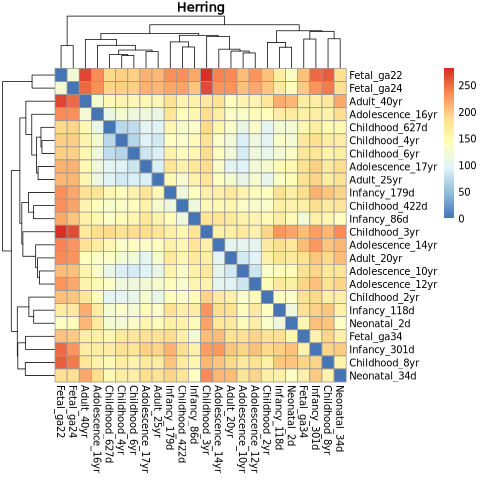

In [9]:
%%R
dds = DESeqDataSet(bulk, design = ~ age)
vsd = vst(dds)
sampleDists = dist(t(assay(vsd)))
sampleDistsMatrix = as.matrix(sampleDists)
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Herring')

In [10]:
%%R
# Save plot
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Herring',
         filename='/group/ll005/cmcphan/notebooks/analysis/results/figures/herring_dists.png')

The ga34 sample is more similar to the neonatal samples than to the fetal samples in terms of expression. Given it is so close to the target timepoint and its similarity with postnatal samples, try removing it from the fetal group so that more of the differences can be captured.

In [11]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
write.csv(res, file=paste(path,'herring_infancy_fetal', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [12]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/herring_infancy_fetal', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TESPA1,439.128057,6.281348,0.833733,7.534000,4.920902e-14,5.744661e-10
ABHD12B,222.920214,3.708184,0.491596,7.543151,4.587509e-14,5.744661e-10
ITPKA,666.262371,4.790064,0.707261,6.772695,1.264049e-11,9.837672e-08
GPR139,292.079387,-3.284557,0.500898,-6.557337,5.477708e-11,3.197338e-07
CSRP2,4239.523280,-4.328169,0.669882,-6.461094,1.039485e-10,4.853977e-07
...,...,...,...,...,...,...
C4orf19,2482.910519,2.993568,0.964721,3.103039,1.915443e-03,4.919885e-02
APOD,171.520650,2.036432,0.656389,3.102477,1.919083e-03,4.923818e-02
C15orf39,62.142795,1.858042,0.599019,3.101809,1.923421e-03,4.929532e-02
RAX2,29.436054,4.123320,1.330433,3.099231,1.940238e-03,4.967179e-02


In [3]:
# Move ga34 sample to neonatal group and rerun DESeq to see how much changes
herring.obs.loc[herring.obs['age']=='ga34', 'stage_id'] = 'Neonatal'
herring.obs[['stage_id', 'age', 'numerical_age']].drop_duplicates().sort_values(by='numerical_age')[0:5]

,stage_id,age,numerical_age
AAACCCAAGAGTCTTC-RL2103_ga22_v3,Fetal,ga22,-0.345205
AAACCCAAGATACAGT-RL2107_ga24_v3,Fetal,ga24,-0.306849
AAACCCAAGGTAGACC-RL2121_ga34_v3,Neonatal,ga34,-0.115068
AAACCCAAGTACAACA-RL1777_2d_v3,Neonatal,2d,0.005479
AAACCTGAGAGTCGGT-RL1612_34d_v2,Neonatal,34d,0.093151


In [14]:
bulk = sc.get.aggregate(herring, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 24 × 26747
    obs: 'stage_id', 'age'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [15]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 26747 24 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(24): Adolescence_10yr Adolescence_12yr ... Neonatal_34d
  Neonatal_ga34
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [16]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
write.csv(res, file=paste(path,'herring_infancy_fetal_no_ga34', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [17]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/herring_infancy_fetal_no_ga34', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AC011288.2,25952.097462,7.120393,0.534044,13.332961,1.488700e-40,3.545637e-36
LY86-AS1,2776.166929,6.658796,0.574895,11.582630,5.047330e-31,6.010613e-27
GRIK1,28621.820827,4.227943,0.424410,9.961923,2.236927e-23,1.775896e-19
HTR1E,1771.507947,4.523687,0.462612,9.778570,1.391625e-22,8.286083e-19
OTOGL,962.799890,5.367183,0.551918,9.724606,2.368201e-22,1.128069e-18
...,...,...,...,...,...,...
GPRIN3,3434.398936,-1.456916,0.522072,-2.790644,5.260329e-03,4.969665e-02
XXbac-BPG252P9.9,19.510889,-2.172361,0.778715,-2.789676,5.276086e-03,4.980683e-02
RP11-673C5.2,2747.983990,-1.277259,0.457853,-2.789670,5.276174e-03,4.980683e-02
RP11-815J21.4,319.047172,-1.816638,0.651331,-2.789117,5.285204e-03,4.987231e-02


Completely changed how the summary looks, called about double the number of DEGs, p-values at the top end much lower than previously

Separate out major cell type catgories, i.e. excitatory neurons, inhibitory neurons, oligodendrocytes, astroglia. Some samples have very low counts for esp. astroglia, particularly in the Sepp data. Try one run with glia grouped together, one with oligodendrocytes and astroglia separated.

In [18]:
herring.obs[['cell_type', 'major_clust']].drop_duplicates()

,cell_type,major_clust
AAACCTGAGAGTCGGT-RL1612_34d_v2,PN,L4_RORB
AAACCTGAGCCGCCTA-RL1612_34d_v2,PN,L2-3_CUX2
AAACCTGAGTCGAGTG-RL1612_34d_v2,IN,SST
AAACCTGCAAGGACTG-RL1612_34d_v2,Non-Neu,Astro
AAACCTGCAGGCGATA-RL1612_34d_v2,PN,L5-6_TLE4
AAACCTGCAGTGGGAT-RL1612_34d_v2,PN,L5-6_THEMIS
AAACCTGGTACTCAAC-RL1612_34d_v2,IN,VIP
AAACCTGGTTACGCGC-RL1612_34d_v2,Non-Neu,OPC
AAACGGGCAATGGATA-RL1612_34d_v2,IN,PV
AAACGGGTCTATCGCC-RL1612_34d_v2,IN,PV_SCUBE3


Herring data already splits principal excitatory neurons (PN), inhibitory neurons (IN) and glia (Non-Neu) so we can use these labels. Non-Neu label includes vasculature which we will exclude as it is not present in other datasets, whereas the glial lineages are.

In [5]:
# Update cell_type category to include separate label for Vas
herring.obs['cell_type'] = herring.obs['cell_type'].cat.set_categories(['IN', 'Non-Neu', 'PN', 'Poor-Quality', 'Vas'])
# Change categorization of Vas cells
herring.obs.loc[herring.obs['major_clust']=='Vas', 'cell_type'] = 'Vas'
herring.obs[['cell_type', 'major_clust']].drop_duplicates()

,cell_type,major_clust
AAACCTGAGAGTCGGT-RL1612_34d_v2,PN,L4_RORB
AAACCTGAGCCGCCTA-RL1612_34d_v2,PN,L2-3_CUX2
AAACCTGAGTCGAGTG-RL1612_34d_v2,IN,SST
AAACCTGCAAGGACTG-RL1612_34d_v2,Non-Neu,Astro
AAACCTGCAGGCGATA-RL1612_34d_v2,PN,L5-6_TLE4
AAACCTGCAGTGGGAT-RL1612_34d_v2,PN,L5-6_THEMIS
AAACCTGGTACTCAAC-RL1612_34d_v2,IN,VIP
AAACCTGGTTACGCGC-RL1612_34d_v2,Non-Neu,OPC
AAACGGGCAATGGATA-RL1612_34d_v2,IN,PV
AAACGGGTCTATCGCC-RL1612_34d_v2,IN,PV_SCUBE3


In [20]:
# Get only the cell types we're interested in
herring_filtered = herring[herring.obs['cell_type'].isin(['PN', 'IN', 'Non-Neu'])]
# Exclude poor quality cells
herring_filtered = herring_filtered[herring_filtered.obs['major_clust']!='Poor-Quality'].copy()
bulk = sc.get.aggregate(herring_filtered, by=['stage_id', 'age', 'cell_type'], func='sum')
# Pseudobulk based on stage and cell type
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 72 × 26747
    obs: 'stage_id', 'age', 'cell_type'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [21]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 26747 72 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(72): Adolescence_10yr_IN Adolescence_10yr_Non-Neu ...
  Neonatal_ga34_Non-Neu Neonatal_ga34_PN
colData names(3): stage_id age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [22]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
    data = data[,data$cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
    write.csv(res, file=paste(path,'herring_infancy_fetal_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Split glial subtypes:

In [15]:
# Relabel glial subtypes
# Update cell_type category to include separate label for Vas
herring.obs['cell_type'] = herring.obs['cell_type'].cat.set_categories(['IN', 'Non-Neu', 'PN', 'Poor-Quality', 'Vas', 'Oligo', 'Astro'])
# Change categorizations
herring.obs.loc[herring.obs['major_clust'].isin(['Oligo', 'OPC']), 'cell_type'] = 'Oligo' # Group oligodendrocytes and precursors together
herring.obs.loc[herring.obs['major_clust'] == 'Astro', 'cell_type'] = 'Astro'
herring.obs[['cell_type', 'major_clust']].drop_duplicates()

,cell_type,major_clust
AAACCTGAGAGTCGGT-RL1612_34d_v2,PN,L4_RORB
AAACCTGAGCCGCCTA-RL1612_34d_v2,PN,L2-3_CUX2
AAACCTGAGTCGAGTG-RL1612_34d_v2,IN,SST
AAACCTGCAAGGACTG-RL1612_34d_v2,Astro,Astro
AAACCTGCAGGCGATA-RL1612_34d_v2,PN,L5-6_TLE4
AAACCTGCAGTGGGAT-RL1612_34d_v2,PN,L5-6_THEMIS
AAACCTGGTACTCAAC-RL1612_34d_v2,IN,VIP
AAACCTGGTTACGCGC-RL1612_34d_v2,Oligo,OPC
AAACGGGCAATGGATA-RL1612_34d_v2,IN,PV
AAACGGGTCTATCGCC-RL1612_34d_v2,IN,PV_SCUBE3


In [24]:
# Get only the cell types we're interested in
herring_filtered = herring[herring.obs['cell_type'].isin(['Oligo', 'Astro'])]
# Exclude poor quality cells
herring_filtered = herring_filtered[herring_filtered.obs['major_clust']!='Poor-Quality'].copy()
bulk = sc.get.aggregate(herring_filtered, by=['stage_id', 'age', 'cell_type'], func='sum')
# Pseudobulk based on stage and cell type
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 48 × 26747
    obs: 'stage_id', 'age', 'cell_type'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [25]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 26747 48 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(48): Adolescence_10yr_Oligo Adolescence_10yr_Astro ...
  Neonatal_ga34_Oligo Neonatal_ga34_Astro
colData names(3): stage_id age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [26]:
%%R
# Rerun for glial subtypes
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
    data = data[,data$cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
    write.csv(res, file=paste(path,'herring_infancy_fetal_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Sepp Human

In [7]:
sepp_human

AnnData object with n_obs × n_vars = 144347 × 27260
    obs: 'orig_cluster', 'orig_sub_cluster', 'broad_lineage', 'cell_type', 'dev_state', 'subtype', 'precisest_label', 'species', 'Tissue', 'TissueID', 'batch', 'Capture.System', 'UMAP1', 'UMAP2', 'Stage', 'stage.ord', 'Stage_exact', 'size_factor', 'sex', 'age', 'fragment', 'rqn_cytoplasm', 'nuclei_preparation', 'chromium_version', 'numerical_age', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'stage_id'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Tissue_colors', 'batch_colors', 'batch_colors_dict', 'batch_order', 'broad_lineage_colors', 'cell_type_colors', 'chromium_version_colors', 'fragment_colors', 'hvg', 'neighbors', 

In [28]:
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_human_filtered = sepp_human[sepp_human.obs['cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_human_filtered = sepp_human_filtered[sepp_human_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_human_filtered, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 14 × 27260
    obs: 'stage_id', 'age'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [29]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 27260 14 
metadata(0):
assays(2): X sum
rownames(27260): ENSG00000237094 ENSG00000230021 ... ENSG00000232464
  ENSG00000227895
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(14): Adult_42yr Adult_46yr ... Infancy_9m Neonatal_5d
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


renaming the first element in assays to 'counts'
converting counts to integer mode


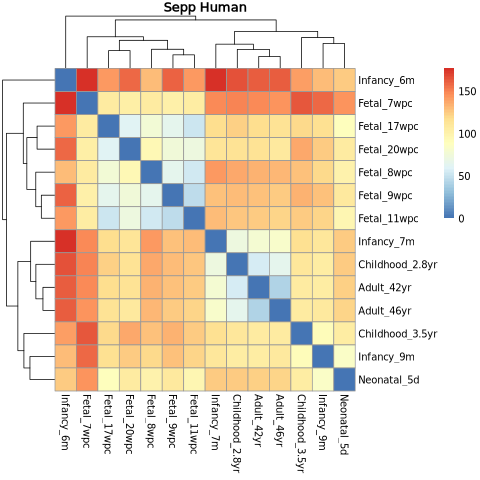

In [30]:
%%R
dds = DESeqDataSet(bulk, design = ~ age)
vsd = vst(dds)
sampleDists = dist(t(assay(vsd)))
sampleDistsMatrix = as.matrix(sampleDists)
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Human')

In [31]:
%%R
# Save plot
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Human',
         filename='/group/ll005/cmcphan/notebooks/analysis/results/figures/sepp_human_dists.png')

In [32]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_human_infancy_fetal', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [33]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/sepp_human_infancy_fetal', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000139899,2306.012768,15.963970,1.024885,15.576352,1.054014e-54,2.399673e-50
ENSG00000163630,5840.557614,5.678869,0.405373,14.009014,1.372988e-44,1.562941e-40
ENSG00000178662,4087.437617,-2.817543,0.218094,-12.918946,3.519272e-38,2.670776e-34
ENSG00000180801,905.901883,6.091245,0.547468,11.126221,9.351670e-29,5.322737e-25
ENSG00000135549,2139.293241,4.675453,0.424274,11.019884,3.064546e-28,1.395410e-24
...,...,...,...,...,...,...
ENSG00000221829,201.621656,-2.839534,1.046934,-2.712237,6.683073e-03,4.962607e-02
ENSG00000233926,1506.093852,2.281039,0.841104,2.711957,6.688727e-03,4.965186e-02
ENSG00000101210,914.293499,1.882993,0.694475,2.711391,6.700164e-03,4.972055e-02
ENSG00000250366,68.633280,-2.924473,1.078974,-2.710420,6.719806e-03,4.985006e-02


Update cell type labels with a new category for broad cell type - 
1. Excitatory = RL/glutamatergic = GC, UBC, NTZ_neuroblast
2. Inhibitory = VZ/GABAergic = Purkinje, interneuron, VZ_neuroblast
3. Glia = oligo, astroglia
Recall that the astroglial type includes a number of precursor types, e.g. (suspected) radial glia, so this group will need to be more manually curated by including only astroglia, microglia to better match the Herring data

In [11]:
sepp_human.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_human.obs['broad_cell_type'] = sepp_human.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Non-Neu', 'Oligo', 'Astro'])
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Non-Neu'
sepp_human.obs.loc[sepp_human.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Non-Neu'
# Grab only cell types that we have verified
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_human_filtered = sepp_human[sepp_human.obs['cell_type'].isin(accepted_cell_types)]
sepp_human_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN003_HUM_CS22_CCCTCCTTCCGATATG-1,GC,PN
SN003_HUM_CS22_CATATTCAGAACAATC-1,astroglia,NaN
SN003_HUM_CS22_GTCCTCATCAGCGACC-1,Purkinje,IN
SN003_HUM_CS22_ACTGTCCGTACCCAAT-1,VZ_neuroblast,IN
SN003_HUM_CS22_GAGCAGAGTCCAAGTT-1,interneuron,IN
SN003_HUM_CS22_CAGCTAAGTTTAGGAA-1,UBC,PN
SN003_HUM_CS22_CGCGTTTCACACTGCG-1,oligo,NaN
SN022_HUM_11wpc_ACTTACTCACCCATTC-1,NTZ_neuroblast,PN


NaN astroglial group is radial glia which will be excluded for this analysis to better match Herring data

In [35]:
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['PN', 'IN', 'Non-Neu']
sepp_human_filtered = sepp_human[sepp_human.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_human_filtered = sepp_human_filtered[sepp_human_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_human_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 40 × 27260
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [36]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 27260 40 
metadata(0):
assays(2): X sum
rownames(27260): ENSG00000237094 ENSG00000230021 ... ENSG00000232464
  ENSG00000227895
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(40): Adult_42yr_PN Adult_42yr_IN ... Neonatal_5d_IN
  Neonatal_5d_Non-Neu
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [37]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_human_infancy_fetal_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify 

In [12]:
# Relabel glial subtypes
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_human.obs.loc[sepp_human.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Astro'
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_human_filtered = sepp_human[sepp_human.obs['cell_type'].isin(accepted_cell_types)]
sepp_human_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN003_HUM_CS22_CCCTCCTTCCGATATG-1,GC,PN
SN003_HUM_CS22_CATATTCAGAACAATC-1,astroglia,NaN
SN003_HUM_CS22_GTCCTCATCAGCGACC-1,Purkinje,IN
SN003_HUM_CS22_ACTGTCCGTACCCAAT-1,VZ_neuroblast,IN
SN003_HUM_CS22_GAGCAGAGTCCAAGTT-1,interneuron,IN
SN003_HUM_CS22_CAGCTAAGTTTAGGAA-1,UBC,PN
SN003_HUM_CS22_CGCGTTTCACACTGCG-1,oligo,Oligo
SN022_HUM_11wpc_ACTTACTCACCCATTC-1,NTZ_neuroblast,PN
SN035_HUM_newborn_TACTTACAGTCTCGGC-1,astroglia,Astro


In [39]:
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['Oligo', 'Astro']
sepp_human_filtered = sepp_human[sepp_human.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_human_filtered = sepp_human_filtered[sepp_human_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_human_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 19 × 27260
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [40]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 27260 19 
metadata(0):
assays(2): X sum
rownames(27260): ENSG00000237094 ENSG00000230021 ... ENSG00000232464
  ENSG00000227895
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(19): Adult_42yr_Oligo Adult_42yr_Astro ... Neonatal_5d_Oligo
  Neonatal_5d_Astro
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [41]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_human_infancy_fetal_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
Error in DESeqDataSet(data, design = ~stage_id) : 
  design has a single variable, with all samples having the same value.
  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used


RInterpreterError: Failed to parse and evaluate line "path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'\ncell_types = c('Oligo', 'Astro')\nfor(c in cell_types){\n    data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]\n    data = data[,data$broad_cell_type == c]\n    dds = DESeqDataSet(data, design=~stage_id)\n    dds = DESeq(dds)\n    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')\n    write.csv(res, file=paste(path,'sepp_human_infancy_fetal_', c, sep=''))\n}\n".
R error message: "Error in DESeqDataSet(data, design = ~stage_id) : \n  design has a single variable, with all samples having the same value.\n  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used"
R stdout:
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
Error in DESeqDataSet(data, design = ~stage_id) : 
  design has a single variable, with all samples having the same value.
  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used

In [42]:
bulk.obs[bulk.obs['broad_cell_type'] == 'Astro']

,stage_id,age,broad_cell_type
Adult_42yr_Astro,Adult,42yr,Astro
Adult_46yr_Astro,Adult,46yr,Astro
Childhood_2.8yr_Astro,Childhood,2.8yr,Astro
Infancy_6m_Astro,Infancy,6m,Astro
Infancy_7m_Astro,Infancy,7m,Astro
Infancy_9m_Astro,Infancy,9m,Astro
Neonatal_5d_Astro,Neonatal,5d,Astro


There are no fetal samples containing astrocytes using this approach. Include the entire 'astroglia' group instead. Note that this may produce significantly different results compared to the Herring astroglial group due to it being mostly radial glia/precursor cells.

In [13]:
# Reload dataset with original labelling
sepp_human = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal_reduced.h5ad')
# Pseudobulk with only the astrocyte group
sepp_human_filtered = sepp_human[sepp_human.obs['cell_type'] == 'astroglia']
# Ignore sample with ambiguous age
sepp_human_filtered = sepp_human_filtered[sepp_human_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_human_filtered, by=['stage_id', 'age', 'cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 13 × 27260
    obs: 'stage_id', 'age', 'cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [44]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 27260 13 
metadata(0):
assays(2): X sum
rownames(27260): ENSG00000237094 ENSG00000230021 ... ENSG00000232464
  ENSG00000227895
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(13): Adult_42yr_astroglia Adult_46yr_astroglia ...
  Infancy_9m_astroglia Neonatal_5d_astroglia
colData names(3): stage_id age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [45]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/stagewise/cell_type_split/'
data = bulk[,bulk$stage_id %in% c('Fetal', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_human_infancy_fetal_Astro', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Sepp Mouse

In [46]:
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_mouse_filtered = sepp_mouse_filtered[sepp_mouse_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_mouse_filtered, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 12 × 20424
    obs: 'stage_id', 'age'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [47]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 20424 12 
metadata(0):
assays(2): X sum
rownames(20424): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000045932 ENSMUSG00000092369
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(12): Adolescence_P14 Adult_9w ... Infancy_P4 Neonatal_P0
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


renaming the first element in assays to 'counts'
converting counts to integer mode


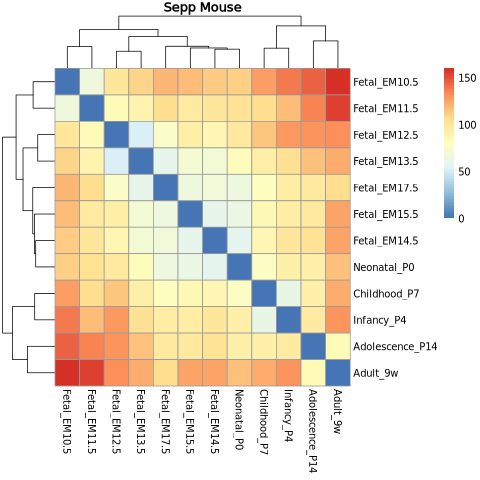

In [48]:
%%R
dds = DESeqDataSet(bulk, design = ~ age)
vsd = vst(dds)
sampleDists = dist(t(assay(vsd)))
sampleDistsMatrix = as.matrix(sampleDists)
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Mouse')

In [49]:
%%R
# Save plot
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Mouse', 
         filename='/group/ll005/cmcphan/notebooks/analysis/results/figures/sepp_mouse_dists.png')

This grouping appears to separate the fetal samples into early and late fetal groups, with the late fetal group beginning at E14.5, with the P0 neonate being quite similar to the E17.5 sample. May be worth comparing the early and late fetal groups to see if there's some significant change happening here. P7 (childhood) and P4 (infancy) are quite similar - may be worth including both of these in the postnatal side of the fetal-infancy comparison. Our only options for looking across eye opening is to compare P7 and 9w, or P14 and 9w. P14 should probably be excluded though as it is too close to the target time point. Since we only have one sample for each of these groups, we'll need to use the agewise comparison for eye-opening.

For across birth we will group the P4 and P7 samples together and use these as the postnatal group, since they cluster together on the similarity map. Prenatal group will consist of only the late fetal samples, up to E17.5, which may need to be excluded as it appears very similar to the neonatal sample. May need to use the early fetal samples instead given the whole late fetal group clusters with the neonatal sample. 

In [14]:
sepp_mouse.obs[['age', 'numerical_age', 'stage_id']].sort_values(by='numerical_age').drop_duplicates()

,age,numerical_age,stage_id
SN108_MOU_E10-5_CCACCTACAAGGTTTC-1,EM10.5,-0.026027,Fetal
SN014_MOU_E11-5_AAAGCAAAGCACCGCT-1,EM11.5,-0.023288,Fetal
SN251_MOU_E12-5_TGTCAGATCGGTCATA-1,EM12.5,-0.020548,Fetal
SN073_MOU_E13-5_CATATTCCACGAAAGC-1,EM13.5,-0.017808,Fetal
SN101_MOU_E14-5_GGAATAAGTAAGTAGT-1,EM14.5,-0.015068,Fetal
SN016_MOU_E15-5_GTCGTAACAGATGGCA-1,EM15.5,-0.012329,Fetal
SN252_MOU_E17-5_AGACCCGGTTATCCAG-1,EM17.5,-0.006849,Fetal
SN127_MOU_P0_AAGACCTTCAATCTCT-1,P0,0.000000,Neonatal
SN039_MOU_P4_GTGAAGGAGTGGTAAT-1,P4,0.010959,Infancy
SN032_MOU_P7_GTATCTTTCGGCTTGG-1,P7,0.019178,Childhood


In [4]:
# Separate early and late fetal samples into different groups and group the P4 and P7 samples together
# Need to update the series to set the new categories first
sepp_mouse.obs['stage_id'] = sepp_mouse.obs['stage_id'].cat.set_categories(['Adolescence', 'Adult', 'Childhood', 
                                                                            'Fetal', 'Infancy', 'Neonatal', 'Fetal_early', 'Fetal_late'])
sepp_mouse.obs.loc[sepp_mouse.obs['age'].isin(['EM10.5', 'EM11.5', 'EM12.5', 'EM13.5']), 'stage_id'] = 'Fetal_early'
sepp_mouse.obs.loc[sepp_mouse.obs['age'].isin(['EM14.5', 'EM15.5', 'EM17.5']), 'stage_id'] = 'Fetal_late'
sepp_mouse.obs.loc[sepp_mouse.obs['age'] == 'P7', 'stage_id'] = 'Infancy'
sepp_mouse.obs[['stage_id', 'age', 'numerical_age']].drop_duplicates().sort_values(by='numerical_age')

,stage_id,age,numerical_age
SN102_MOU_E10-5_GCCTCTATCATCTGCC-1,Fetal_early,EM10.5,-0.026027
SN010_MOU_E11-5_GGCAATTTCCTTTCGG-1,Fetal_early,EM11.5,-0.023288
SN126_MOU_E12-5_CGTGAGCAGAATCTCC-1,Fetal_early,EM12.5,-0.020548
SN006_MOU_E13-5_CACATTTCACGCATCG-1,Fetal_early,EM13.5,-0.017808
SN088_MOU_E14-5_TTCTCCTCATTCCTCG-1,Fetal_late,EM14.5,-0.015068
SN016_MOU_E15-5_TAGCCGGCAAATTGCC-1,Fetal_late,EM15.5,-0.012329
SN106_MOU_E17-5_TCTCATATCCGTAGTA-1,Fetal_late,EM17.5,-0.006849
SN127_MOU_P0_TACGGTAGTACTTCTT-1,Neonatal,P0,0.000000
SN038_MOU_P4_AGTGGGATCGTTACAG-1,Infancy,P4,0.010959
SN025_MOU_P7_TCACAAGGTCAATGTC-1,Infancy,P7,0.019178


In [52]:
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_mouse_filtered = sepp_mouse_filtered[sepp_mouse_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_mouse_filtered, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 12 × 20424
    obs: 'stage_id', 'age'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [53]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 20424 12 
metadata(0):
assays(2): X sum
rownames(20424): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000045932 ENSMUSG00000092369
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(12): Adolescence_P14 Adult_9w ... Fetal_late_EM15.5
  Fetal_late_EM17.5
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [54]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal_late', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_late'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_late', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


In [55]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/sepp_mouse_infancy_fetal_late', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000027395,1785.582772,3.841760,0.201613,19.055111,5.959039e-81,9.669733e-77
ENSMUSG00000012819,532.479895,3.309247,0.215742,15.338908,4.202028e-53,3.409315e-49
ENSMUSG00000052305,1064.364377,-3.917006,0.271154,-14.445689,2.668753e-47,1.443528e-43
ENSMUSG00000086166,322.896502,4.461480,0.321984,13.856227,1.166459e-43,4.732034e-40
ENSMUSG00000030867,142.525776,3.415239,0.266402,12.819884,1.268895e-37,4.118072e-34
...,...,...,...,...,...,...
ENSMUSG00000032977,87.742251,1.121448,0.421999,2.657466,7.873050e-03,4.978799e-02
ENSMUSG00000029101,108.072940,-0.874041,0.329008,-2.656593,7.893477e-03,4.988359e-02
ENSMUSG00000059791,71.540039,0.954388,0.359275,2.656426,7.897389e-03,4.988359e-02
ENSMUSG00000030199,280.508473,-0.593802,0.223530,-2.656479,7.896145e-03,4.988359e-02


In [56]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal_late', 'Fetal_early')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Fetal_late', 'Fetal_early'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_mouse_fetal_late_early', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [57]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/sepp_mouse_fetal_late_early', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000085845,604.848380,4.271163,0.476496,8.963688,3.139954e-19,4.967094e-15
ENSMUSG00000004630,85.188398,10.346599,1.202875,8.601554,7.864363e-18,6.220318e-14
ENSMUSG00000031673,1334.711324,2.265789,0.271952,8.331587,7.976607e-17,4.206065e-13
ENSMUSG00000027016,968.446055,3.451715,0.430085,8.025662,1.009801e-15,3.993511e-12
ENSMUSG00000056755,2971.339548,3.751238,0.486948,7.703568,1.323186e-14,4.186295e-11
...,...,...,...,...,...,...
ENSMUSG00000030678,309.939419,-0.630920,0.208747,-3.022412,2.507686e-03,4.954078e-02
ENSMUSG00000086815,62.169549,-1.525730,0.504927,-3.021684,2.513726e-03,4.958184e-02
ENSMUSG00000018583,913.985229,-1.173847,0.388642,-3.020380,2.524577e-03,4.967199e-02
ENSMUSG00000061576,3394.733919,1.430771,0.473698,3.020425,2.524198e-03,4.967199e-02


In [58]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/'
data = bulk[,bulk$stage_id %in% c('Fetal_early', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_early'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_early', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [59]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/sepp_mouse_infancy_fetal_early', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMUSG00000096914,3275.714555,4.142402,0.258248,16.040377,6.674751e-58,1.069829e-53
ENSMUSG00000004630,465.457215,13.453631,1.073294,12.534904,4.809457e-36,3.854299e-32
ENSMUSG00000030342,768.110817,3.869752,0.319031,12.129702,7.351608e-34,3.927719e-30
ENSMUSG00000028033,1935.225582,4.247428,0.353974,11.999259,3.584926e-33,1.436480e-29
ENSMUSG00000105640,382.707090,13.170531,1.107150,11.895888,1.243241e-32,3.985332e-29
...,...,...,...,...,...,...
ENSMUSG00000085178,25.516013,-6.592910,2.524269,-2.611810,9.006433e-03,4.970906e-02
ENSMUSG00000020184,354.623977,-0.753985,0.288739,-2.611301,9.019842e-03,4.976593e-02
ENSMUSG00000038214,65.958357,-1.284458,0.492043,-2.610460,9.042058e-03,4.987134e-02
ENSMUSG00000021306,132.822708,-0.935105,0.358276,-2.610011,9.053921e-03,4.991884e-02


In [60]:
sepp_mouse.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_mouse.obs['broad_cell_type'] = sepp_mouse.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Non-Neu', 'Oligo', 'Astro'])
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Non-Neu'
sepp_mouse.obs.loc[sepp_mouse.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Non-Neu'
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['cell_type'].isin(accepted_cell_types)]
sepp_mouse_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN006_MOU_E13-5_CACATTTCACGCATCG-1,interneuron,IN
SN006_MOU_E13-5_CAGGTGCTCCAGGGCT-1,astroglia,NaN
SN006_MOU_E13-5_TCACGAAGTGCCTGCA-1,Purkinje,IN
SN006_MOU_E13-5_TGACAACGTACATCCA-1,VZ_neuroblast,IN
SN006_MOU_E13-5_AACTCTTAGGGAACGG-1,GC,PN
SN006_MOU_E13-5_CTTCTCTCAGCTTCGG-1,NTZ_neuroblast,PN
SN010_MOU_E11-5_CTCACACGTCTAGTCA-1,oligo,Non-Neu
SN015_MOU_E13-5_ACTATCTCAATAGCGG-1,astroglia,Non-Neu
SN016_MOU_E15-5_GAAATGATCATCATTC-1,UBC,PN


In [61]:
accepted_cell_types = ['PN', 'IN', 'Non-Neu']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_mouse_filtered = sepp_mouse_filtered[sepp_mouse_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_mouse_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 34 × 20424
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [62]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 20424 34 
metadata(0):
assays(2): X sum
rownames(20424): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000045932 ENSMUSG00000092369
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(34): Adolescence_P14_PN Adolescence_P14_IN ...
  Fetal_late_EM17.5_IN Fetal_late_EM17.5_Non-Neu
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [63]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal_late', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_late'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_late_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [64]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal_early', 'Fetal_late')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Fetal_late', 'Fetal_early'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_fetal_late_early_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify 

In [65]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal_early', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_early'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_early_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify 

Single age comparisons for eye-opening cannot be split by cell type because we were using cell types as pseudo-samples. Trying to do this while splitting out cell types like above will fail because it is computationally singular

Split glial subtypes:

In [66]:
# Relabel glial subtypes
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_mouse.obs.loc[sepp_mouse.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Astro'
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['cell_type'].isin(accepted_cell_types)]
sepp_mouse_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN006_MOU_E13-5_CACATTTCACGCATCG-1,interneuron,IN
SN006_MOU_E13-5_CAGGTGCTCCAGGGCT-1,astroglia,NaN
SN006_MOU_E13-5_TCACGAAGTGCCTGCA-1,Purkinje,IN
SN006_MOU_E13-5_TGACAACGTACATCCA-1,VZ_neuroblast,IN
SN006_MOU_E13-5_AACTCTTAGGGAACGG-1,GC,PN
SN006_MOU_E13-5_CTTCTCTCAGCTTCGG-1,NTZ_neuroblast,PN
SN010_MOU_E11-5_CTCACACGTCTAGTCA-1,oligo,Oligo
SN015_MOU_E13-5_ACTATCTCAATAGCGG-1,astroglia,Astro
SN016_MOU_E15-5_GAAATGATCATCATTC-1,UBC,PN


In [67]:
accepted_cell_types = ['Oligo', 'Astro']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_mouse_filtered = sepp_mouse_filtered[sepp_mouse_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_mouse_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 18 × 20424
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [68]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 20424 18 
metadata(0):
assays(2): X sum
rownames(20424): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000045932 ENSMUSG00000092369
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(18): Adolescence_P14_Oligo Adolescence_P14_Astro ...
  Fetal_late_EM17.5_Oligo Fetal_late_EM17.5_Astro
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [69]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Infancy', 'Fetal_late')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_late'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_late_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing


In [70]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal_early', 'Fetal_late')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Fetal_late', 'Fetal_early'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_fetal_late_early_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [71]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Fetal_early', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Fetal_early'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_mouse_infancy_fetal_late_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


### Sepp Opossum

In [72]:
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['cell_type'].isin(accepted_cell_types)]
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 10 × 28773
    obs: 'stage_id', 'age'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [73]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 10 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(10): Adolescence_P42 Adolescence_P60 ... Neonatal_P4
  Neonatal_P5
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


renaming the first element in assays to 'counts'
converting counts to integer mode


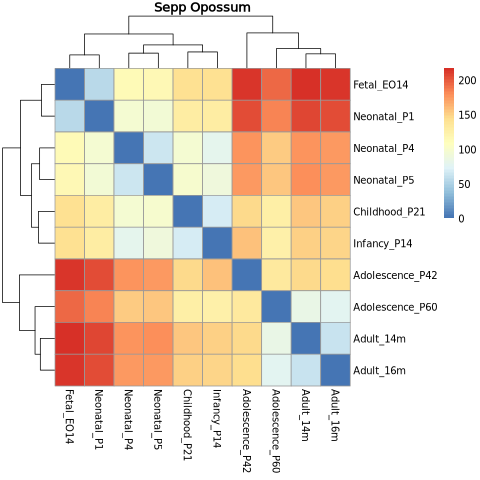

In [74]:
%%R
dds = DESeqDataSet(bulk, design = ~ age)
vsd = vst(dds)
sampleDists = dist(t(assay(vsd)))
sampleDistsMatrix = as.matrix(sampleDists)
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Opossum')

In [75]:
%%R
# Save plot
pheatmap(sampleDistsMatrix, clustering_distance_rows=sampleDists, clustering_distance_cols=sampleDists, main='Sepp Opossum',
         filename='/group/ll005/cmcphan/notebooks/analysis/results/figures/sepp_opossum_dists.png')

We have no real fetal samples to compare across birth with, so we'll need to use other milestones for the opossum. We can still compare what we find at other points with the changes seen in birth in other species to try determine whether similar changes are occurring, but we won't be able to compare changes at birth directly. The early neonatal samples cluster in a couple of different groups, so we could look at early versus late neonatal, late neonatal versus infancy, etc. As with the mouse, the childhood and infancy samples (here P14 and P21) cluster together and appear quite similar, so we will group these together. Eye-opening for the Monodelphis domestica species occurs at around P30, so our comparison for this will be the infancy (P14 and P21) and adolescent (P42 and P60) groups.

In [5]:
# Separate early and late fetal samples into different groups and group the P4 and P7 samples together
# Need to update the series to set the new categories first
sepp_opossum.obs['stage_id'] = sepp_opossum.obs['stage_id'].cat.set_categories(['Adolescence', 'Adult', 'Childhood', 
                                                                            'Fetal', 'Infancy', 'Neonatal', 'Neonatal_early', 'Neonatal_late'])
sepp_opossum.obs.loc[sepp_opossum.obs['age'].isin(['EO14', 'P1']), 'stage_id'] = 'Neonatal_early'
sepp_opossum.obs.loc[sepp_opossum.obs['age'].isin(['P4', 'P5']), 'stage_id'] = 'Neonatal_late'
sepp_opossum.obs.loc[sepp_opossum.obs['age'] == 'P21', 'stage_id'] = 'Infancy'
sepp_opossum.obs[['stage_id', 'age', 'numerical_age']].drop_duplicates().sort_values(by='numerical_age')

,stage_id,age,numerical_age
SN174_OPO_E14-25_AGTAACCAGGACAGTC-1,Neonatal_early,EO14,-0.002740
SN208_OPO_P1_TGTCCACGTCGCATTA-1,Neonatal_early,P1,0.002740
SN155_OPO_P4_CGCCAGAAGAAAGCGA-1,Neonatal_late,P4,0.010959
SN070_OPO_P5_CATTATCAGAGCAATT-1,Neonatal_late,P5,0.013699
SN152_OPO_P14_TCATTTGTCATTCACT-1,Infancy,P14,0.038356
SN109_OPO_P21_TTAGGACTCTGTCAAG-1,Infancy,P21,0.057534
SN065_OPO_P42_CAACTAGGTTCAGGCC-1,Adolescence,P42,0.115068
SN204_OPO_P60_TCCAGAACATCGCTGG-1,Adolescence,P60,0.164384
SN148_OPO_adult_ATCTTCACAATCTAGC-1,Adult,14m,1.166667
SN147_OPO_adult_ATTCACTCAAGGCGTA-1,Adult,16m,1.333333


In [77]:
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['cell_type'].isin(accepted_cell_types)]
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['stage_id', 'age'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 10 × 28773
    obs: 'stage_id', 'age'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [78]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 10 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(10): Adolescence_P42 Adolescence_P60 ... Neonatal_late_P4
  Neonatal_late_P5
colData names(2): stage_id age
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [79]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/'
data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Neonatal_early')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Neonatal_late', 'Neonatal_early'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_opossum_neonatal_late_early', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [80]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/sepp_opossum_neonatal_late_early', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMODG00000021453,7003.368422,3.506546,0.139714,25.098110,5.215279e-139,1.234978e-134
ENSMODG00000007628,4265.407811,9.341126,0.381638,24.476399,2.635324e-132,3.120223e-128
ENSMODG00000005322,10100.973062,3.830743,0.163529,23.425449,2.352623e-121,1.857003e-117
ENSMODG00000020267,6049.605642,4.275405,0.185072,23.101249,4.498019e-118,2.662827e-114
ENSMODG00000036060,1096.710202,6.425683,0.301679,21.299757,1.141111e-100,5.404299e-97
...,...,...,...,...,...,...
ENSMODG00000012694,845.297759,0.767131,0.286868,2.674157,7.491747e-03,4.963754e-02
XLOC_075653,1489.131076,1.507633,0.563908,2.673542,7.505496e-03,4.971473e-02
XLOC_058208,435.547575,-1.165249,0.435861,-2.673439,7.507796e-03,4.971606e-02
XLOC_070502,54.389719,3.942835,1.474890,2.673308,7.510723e-03,4.972153e-02


In [81]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/'
data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Infancy', 'Neonatal_late'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_opossum_infancy_neonatal_late', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [82]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/sepp_opossum_infancy_neonatal_late', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMODG00000002720,3955.153928,-5.273753,0.203555,-25.908274,5.373249e-148,1.290386e-143
ENSMODG00000017859,3873.952462,4.088535,0.173859,23.516363,2.774374e-122,3.331329e-118
ENSMODG00000015438,41022.620693,6.567766,0.293252,22.396341,4.272658e-111,3.420263e-107
ENSMODG00000019273,111823.968292,3.240564,0.158299,20.471159,3.892524e-93,2.336974e-89
ENSMODG00000002553,6279.464323,3.312091,0.166697,19.868969,7.553881e-88,3.628129e-84
...,...,...,...,...,...,...
XLOC_070750,15.853254,7.020684,2.427921,2.891645,3.832312e-03,4.913666e-02
ENSMODG00000015073,62.891009,3.216140,1.112283,2.891475,3.834379e-03,4.913693e-02
ENSMODG00000010133,3635.454396,0.636168,0.220235,2.888585,3.869800e-03,4.956440e-02
ENSMODG00000025259,485.036728,0.932323,0.322821,2.888049,3.876400e-03,4.960257e-02


In [83]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/'
data = bulk[,bulk$stage_id %in% c('Adolescence', 'Infancy')]
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Adolescence', 'Infancy'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_opossum_adolescence_infancy', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [84]:
results = pd.read_csv('/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/sepp_opossum_adolescence_infancy', index_col=0).sort_values(by='padj')
sig = results[results['padj'] <= 0.05]
sig

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSMODG00000001290,2054.568898,4.076458,0.291542,13.982427,1.995644e-44,4.142158e-40
ENSMODG00000013970,12599.920044,3.746661,0.292053,12.828699,1.132492e-37,1.175300e-33
ENSMODG00000015863,5367.451908,-3.344733,0.264326,-12.653818,1.065674e-36,7.373040e-33
ENSMODG00000019131,2297.882840,-4.720791,0.384162,-12.288535,1.043809e-34,5.416324e-31
ENSMODG00000012366,730.332518,5.115344,0.456755,11.199323,4.108611e-29,1.421305e-25
...,...,...,...,...,...,...
ENSMODG00000005145,233.756159,-1.639685,0.587251,-2.792136,5.236130e-03,4.974461e-02
ENSMODG00000008827,486.507330,1.419986,0.508618,2.791849,5.240774e-03,4.974461e-02
XLOC_049185,20.412816,-6.717953,2.406965,-2.791048,5.253776e-03,4.981607e-02
ENSMODG00000030312,20.794959,-6.740262,2.415235,-2.790728,5.258973e-03,4.984257e-02


In [85]:
# Add broad cell type labels
sepp_opossum.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_opossum.obs['broad_cell_type'] = sepp_opossum.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Non-Neu', 'Oligo', 'Astro'])
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Non-Neu'
sepp_opossum.obs.loc[sepp_opossum.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Non-Neu'
# Grab only our highly variable genes as input for cell types that we have verified
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['cell_type'].isin(accepted_cell_types)]
sepp_opossum_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN065_OPO_P42_CAACTAGGTTCAGGCC-1,GC,PN
SN065_OPO_P42_CCTTCGATCCTCATTA-1,interneuron,IN
SN065_OPO_P42_CCTATTATCCAAACTG-1,oligo,Non-Neu
SN065_OPO_P42_TTCTACATCCATGCTC-1,UBC,PN
SN065_OPO_P42_AACTCTTGTACCGTTA-1,astroglia,Non-Neu
SN070_OPO_P5_TAAGAGAAGTGGGCTA-1,Purkinje,IN
SN070_OPO_P5_GGTATTGTCGTGGACC-1,astroglia,NaN
SN070_OPO_P5_AAGGTTCTCATTGCCC-1,VZ_neuroblast,IN
SN155_OPO_P4_CAAAGAACAACCGTAT-1,NTZ_neuroblast,PN


In [86]:
accepted_cell_types = ['PN', 'IN', 'Non-Neu']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_opossum_filtered = sepp_opossum_filtered[sepp_opossum_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 28 × 28773
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [87]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 28 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(28): Adolescence_P42_PN Adolescence_P42_IN ...
  Neonatal_late_P5_IN Neonatal_late_P5_Non-Neu
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [88]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Neonatal_early')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Neonatal_late', 'Neonatal_early'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_opossum_neonatal_late_early_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
Error in DESeqDataSet(data, design = ~stage_id) : 
  design has a single variable, with all samples having the same value.
  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used


RInterpreterError: Failed to parse and evaluate line "path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'\ncell_types = c('PN', 'IN', 'Non-Neu')\nfor(c in cell_types){\n    data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Neonatal_early')]\n    data = data[,data$broad_cell_type == c]\n    dds = DESeqDataSet(data, design=~stage_id)\n    dds = DESeq(dds)\n    res = results(dds, contrast=c('stage_id', 'Neonatal_late', 'Neonatal_early'), format='DataFrame')\n    write.csv(res, file=paste(path,'sepp_opossum_neonatal_late_early_', c, sep=''))\n}\n".
R error message: "Error in DESeqDataSet(data, design = ~stage_id) : \n  design has a single variable, with all samples having the same value.\n  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used"
R stdout:
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
Error in DESeqDataSet(data, design = ~stage_id) : 
  design has a single variable, with all samples having the same value.
  use instead a design of '~ 1'. estimateSizeFactors, rlog and the VST can then be used

In [89]:
bulk.obs

,stage_id,age,broad_cell_type
Adolescence_P42_PN,Adolescence,P42,PN
Adolescence_P42_IN,Adolescence,P42,IN
Adolescence_P42_Non-Neu,Adolescence,P42,Non-Neu
Adolescence_P60_PN,Adolescence,P60,PN
Adolescence_P60_IN,Adolescence,P60,IN
Adolescence_P60_Non-Neu,Adolescence,P60,Non-Neu
Adult_14m_PN,Adult,14m,PN
Adult_14m_IN,Adult,14m,IN
Adult_14m_Non-Neu,Adult,14m,Non-Neu
Adult_16m_PN,Adult,16m,PN


Early neonatal groups do not have any Non-Neu cells - need to use full astroglial grouping for these. This will be entirely radial glia/precursor cells, so results may not track well with other species. See end of section.

In [90]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Neonatal_late'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_opossum_infancy_neonatal_late_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [91]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
cell_types = c('PN', 'IN', 'Non-Neu')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Adolescence', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Adolescence', 'Infancy'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_opossum_adolescence_infancy_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Split glial subtypes:

In [92]:
# Relabel glial subtypes
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_opossum.obs.loc[sepp_opossum.obs['precisest_label'].isin(['astro_Bergmann', 'astro_parenh', 'astroblast']), 'broad_cell_type'] = 'Astro'
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['cell_type'].isin(accepted_cell_types)]
sepp_opossum_filtered.obs[['cell_type', 'broad_cell_type']].drop_duplicates()

,cell_type,broad_cell_type
SN065_OPO_P42_CAACTAGGTTCAGGCC-1,GC,PN
SN065_OPO_P42_CCTTCGATCCTCATTA-1,interneuron,IN
SN065_OPO_P42_CCTATTATCCAAACTG-1,oligo,Oligo
SN065_OPO_P42_TTCTACATCCATGCTC-1,UBC,PN
SN065_OPO_P42_AACTCTTGTACCGTTA-1,astroglia,Astro
SN070_OPO_P5_TAAGAGAAGTGGGCTA-1,Purkinje,IN
SN070_OPO_P5_GGTATTGTCGTGGACC-1,astroglia,NaN
SN070_OPO_P5_AAGGTTCTCATTGCCC-1,VZ_neuroblast,IN
SN155_OPO_P4_CAAAGAACAACCGTAT-1,NTZ_neuroblast,PN


In [93]:
accepted_cell_types = ['Oligo', 'Astro']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['broad_cell_type'].isin(accepted_cell_types)]
# Ignore sample with ambiguous age
sepp_opossum_filtered = sepp_opossum_filtered[sepp_opossum_filtered.obs['stage_id']!='None']
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 15 × 28773
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [94]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 15 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(15): Adolescence_P42_Oligo Adolescence_P42_Astro ...
  Neonatal_late_P5_Oligo Neonatal_late_P5_Astro
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [95]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Infancy', 'Neonatal_late'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_opossum_infancy_neonatal_late_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [96]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
cell_types = c('Oligo', 'Astro')
for(c in cell_types){
    data = bulk[,bulk$stage_id %in% c('Adolescence', 'Infancy')]
    data = data[,data$broad_cell_type == c]
    dds = DESeqDataSet(data, design=~stage_id)
    dds = DESeq(dds)
    res = results(dds, contrast=c('stage_id', 'Adolescence', 'Infancy'), format='DataFrame')
    write.csv(res, file=paste(path,'sepp_opossum_adolescence_infancy_', c, sep=''))
}

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


Early neonatal samples have no oligo/astroglial populations, so early vs late neonatal comparisons can't be done for these types

Use full astroglial grouping (including radial glia/precursors) for early vs late neonatal since the early samples do not contain oligos or astros otherwise:

In [97]:
# Relabel all astroglia
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'
# Grab only the astros - no oligos in these samples
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['broad_cell_type'] == 'Astro']
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['stage_id', 'age', 'broad_cell_type'], func='sum')
# Pseudobulk based on stage
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 10 × 28773
    obs: 'stage_id', 'age', 'broad_cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [98]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 10 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(10): Adolescence_P42_Astro Adolescence_P60_Astro ...
  Neonatal_late_P4_Astro Neonatal_late_P5_Astro
colData names(3): stage_id age broad_cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [99]:
%%R
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/stagewise/cell_type_split/'
data = bulk[,bulk$stage_id %in% c('Neonatal_late', 'Neonatal_early')]
data = data[,data$broad_cell_type == 'Astro']
dds = DESeqDataSet(data, design=~stage_id)
dds = DESeq(dds)
res = results(dds, contrast=c('stage_id', 'Neonatal_late', 'Neonatal_early'), format='DataFrame')
write.csv(res, file=paste(path,'sepp_opossum_neonatal_late_early_Astro', sep=''))

renaming the first element in assays to 'counts'
converting counts to integer mode
factor levels were dropped which had no samples
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


---
### Figures

In [6]:
sepp_human.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_human.obs['broad_cell_type'] = sepp_human.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_human.obs.loc[sepp_human.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_human.obs.loc[sepp_human.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']

In [7]:
sepp_mouse.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_mouse.obs['broad_cell_type'] = sepp_mouse.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_mouse.obs.loc[sepp_mouse.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'

In [8]:
sepp_opossum.obs['broad_cell_type'] = pd.Series(dtype='category')
sepp_opossum.obs['broad_cell_type'] = sepp_opossum.obs['broad_cell_type'].cat.set_categories(['PN', 'IN', 'Oligo', 'Astro'])
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['GC', 'UBC', 'NTZ_neuroblast']), 'broad_cell_type'] = 'PN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'].isin(['Purkinje', 'interneuron', 'VZ_neuroblast']), 'broad_cell_type'] = 'IN'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'oligo', 'broad_cell_type'] = 'Oligo'
sepp_opossum.obs.loc[sepp_opossum.obs['cell_type'] == 'astroglia', 'broad_cell_type'] = 'Astro'

In [9]:
herring.obs['stage_type'] = [str(s+'_'+c) for s, c in zip(herring.obs['stage_id'].values.tolist(), herring.obs['cell_type'].values.tolist())]
herring.obs[['stage_id', 'cell_type', 'stage_type']]

,stage_id,cell_type,stage_type
AAACCTGAGAGTCGGT-RL1612_34d_v2,Neonatal,PN,Neonatal_PN
AAACCTGAGCCGCCTA-RL1612_34d_v2,Neonatal,PN,Neonatal_PN
AAACCTGAGTCGAGTG-RL1612_34d_v2,Neonatal,IN,Neonatal_IN
AAACCTGAGTGAACAT-RL1612_34d_v2,Neonatal,PN,Neonatal_PN
AAACCTGCAAGGACTG-RL1612_34d_v2,Neonatal,Non-Neu,Neonatal_Non-Neu
...,...,...,...
TTTGTTGCACCAGCGT-RL2132_25yr_v3,Adult,IN,Adult_IN
TTTGTTGCACCGCTGA-RL2132_25yr_v3,Adult,IN,Adult_IN
TTTGTTGGTAAGGTCG-RL2132_25yr_v3,Adult,Non-Neu,Adult_Non-Neu
TTTGTTGGTTCGGCTG-RL2132_25yr_v3,Adult,PN,Adult_PN


In [10]:
for data in [sepp_human, sepp_mouse, sepp_opossum]:
    data.obs['broad_cell_type'] = ['None' if g is np.nan else g for g in data.obs['broad_cell_type']]
    data.obs['stage_type'] = [str(s+'_'+c) for s, c in zip(data.obs['stage_id'].values.tolist(), data.obs['broad_cell_type'].values.tolist())]

In [11]:
import matplotlib

In [131]:
def get_palette(groups, data):
    palette = matplotlib.colormaps['seismic'].resampled(10)
    palette = palette([0,1,2,3,6,7,8,9])
    remaining = [g for g in set(data.obs['stage_type'].values.tolist()) if g not in groups]
    colours = {g:c for g, c in zip(groups, palette)}
    for g in remaining:
        colours[g] = 'lightgray'
    return colours

In [164]:
# Palette for agewise mouse comp at eye-opening
palette = matplotlib.colormaps['seismic'].resampled(10)
agewise_colours = {g:c for g,c in zip(['9w', 'P7'], palette([2,7]))}
remaining = [g for g in set(sepp_mouse.obs['age'].values.tolist()) if g not in ['9w', 'P7']]
for g in remaining:
    agewise_colours[g] = 'lightgray'
agewise_colours

{'9w': array([0.        , 0.        , 0.92222222, 1.        ]),
 'P7': array([0.94444444, 0.        , 0.        , 1.        ]),
 'EM11.5': 'lightgray',
 'P0': 'lightgray',
 'EM15.5': 'lightgray',
 'P4': 'lightgray',
 'EM10.5': 'lightgray',
 'EM13.5': 'lightgray',
 'EM14.5': 'lightgray',
 'EM12.5': 'lightgray',
 'EM17.5': 'lightgray',
 'P14': 'lightgray'}

In [13]:
import matplotlib.pyplot as plt

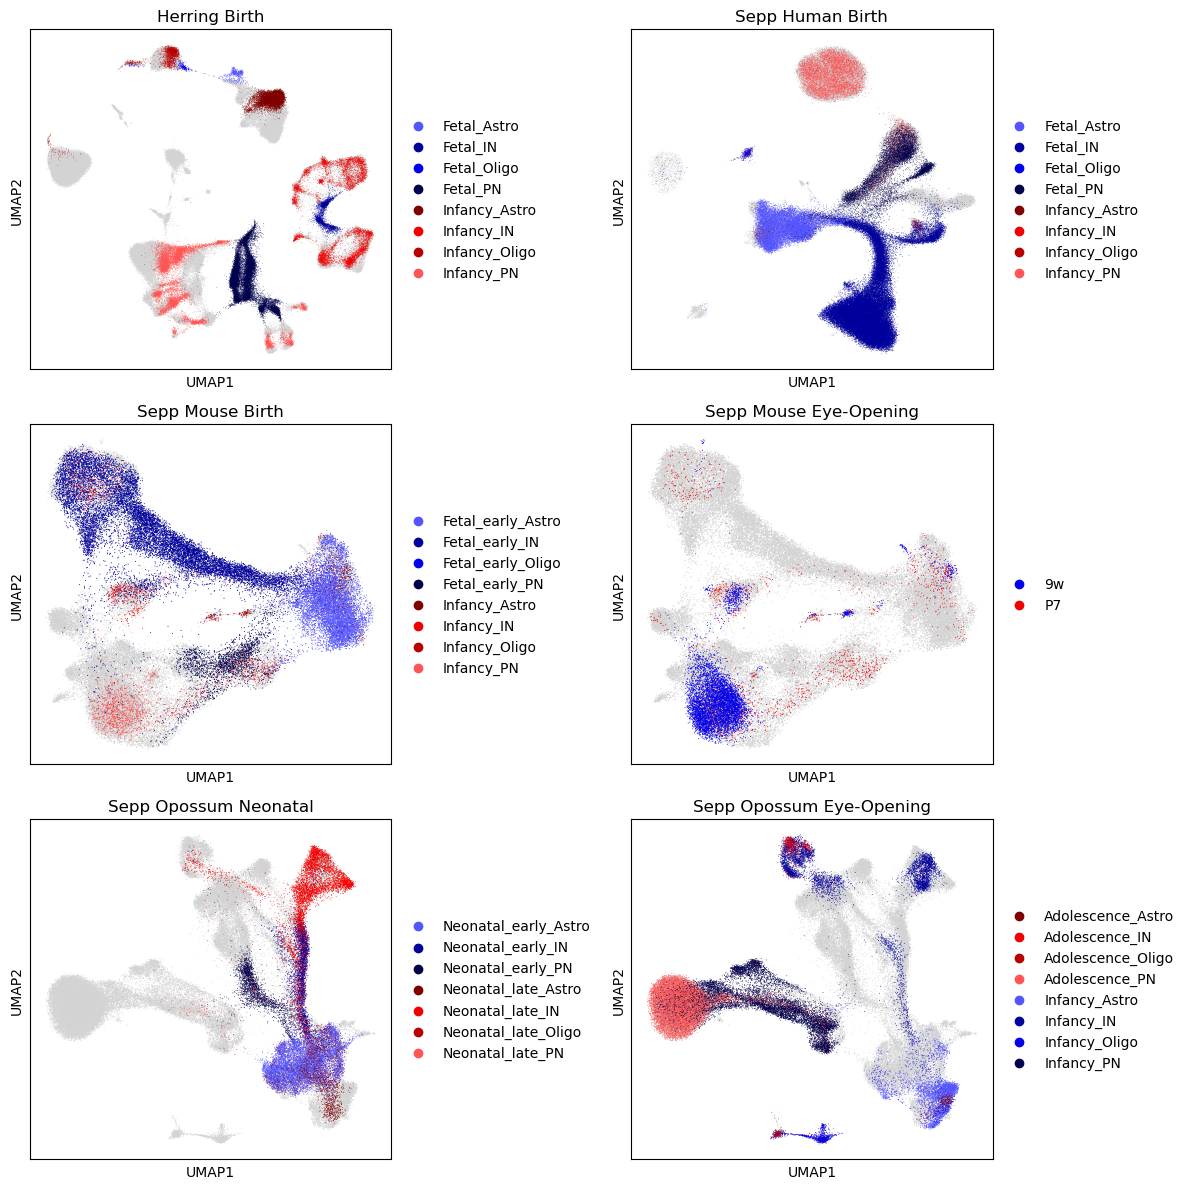

In [186]:
nrows = 3
ncols = 2
figsize = 4
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, 
                        figsize=(ncols * figsize + figsize * (ncols-1), nrows * figsize))
groups = ['Fetal_PN', 'Fetal_IN', 'Fetal_Oligo', 'Fetal_Astro', 'Infancy_PN', 'Infancy_IN', 'Infancy_Oligo', 'Infancy_Astro']
sc.pl.umap(herring, color='stage_type', groups=groups, na_in_legend=False, palette=get_palette(groups, herring), 
           title='Herring Birth', ax=axs[0,0], show=False)
sc.pl.umap(sepp_human, color='stage_type', groups=groups, na_in_legend=False, palette=get_palette(groups, sepp_human), 
           title='Sepp Human Birth', ax=axs[0,1], show=False)
groups = ['Fetal_early_PN', 'Fetal_early_IN', 'Fetal_early_Oligo', 'Fetal_early_Astro', 
          'Infancy_PN', 'Infancy_IN', 'Infancy_Oligo', 'Infancy_Astro']
sc.pl.umap(sepp_mouse, color='stage_type', groups=groups, na_in_legend=False, palette=get_palette(groups, sepp_mouse), 
           title='Sepp Mouse Birth', ax=axs[1,0], show=False)
sc.pl.umap(sepp_mouse, color='age', groups=['9w', 'P7'], na_in_legend=False, palette=agewise_colours, 
           title='Sepp Mouse Eye-Opening', ax=axs[1,1], show=False)
groups = ['Neonatal_early_PN', 'Neonatal_early_IN', 'Neonatal_early_Oligo', 'Neonatal_early_Astro', 
          'Neonatal_late_PN', 'Neonatal_late_IN', 'Neonatal_late_Oligo', 'Neonatal_late_Astro']
sc.pl.umap(sepp_opossum, color='stage_type', groups=groups, na_in_legend=False, palette=get_palette(groups, sepp_opossum), 
           title='Sepp Opossum Neonatal', ax=axs[2,0], show=False)
groups = ['Infancy_PN', 'Infancy_IN', 'Infancy_Oligo', 'Infancy_Astro', 
          'Adolescence_PN', 'Adolescence_IN', 'Adolescence_Oligo', 'Adolescence_Astro']
sc.pl.umap(sepp_opossum, color='stage_type', groups=groups, na_in_legend=False, palette=get_palette(groups, sepp_opossum), 
           title='Sepp Opossum Eye-Opening', ax=axs[2,1], show=False)
plt.tight_layout()
plt.savefig(str(FIG_PATH+'pseudobulk_umap.png'), dpi=300, bbox_inches='tight')
plt.show()

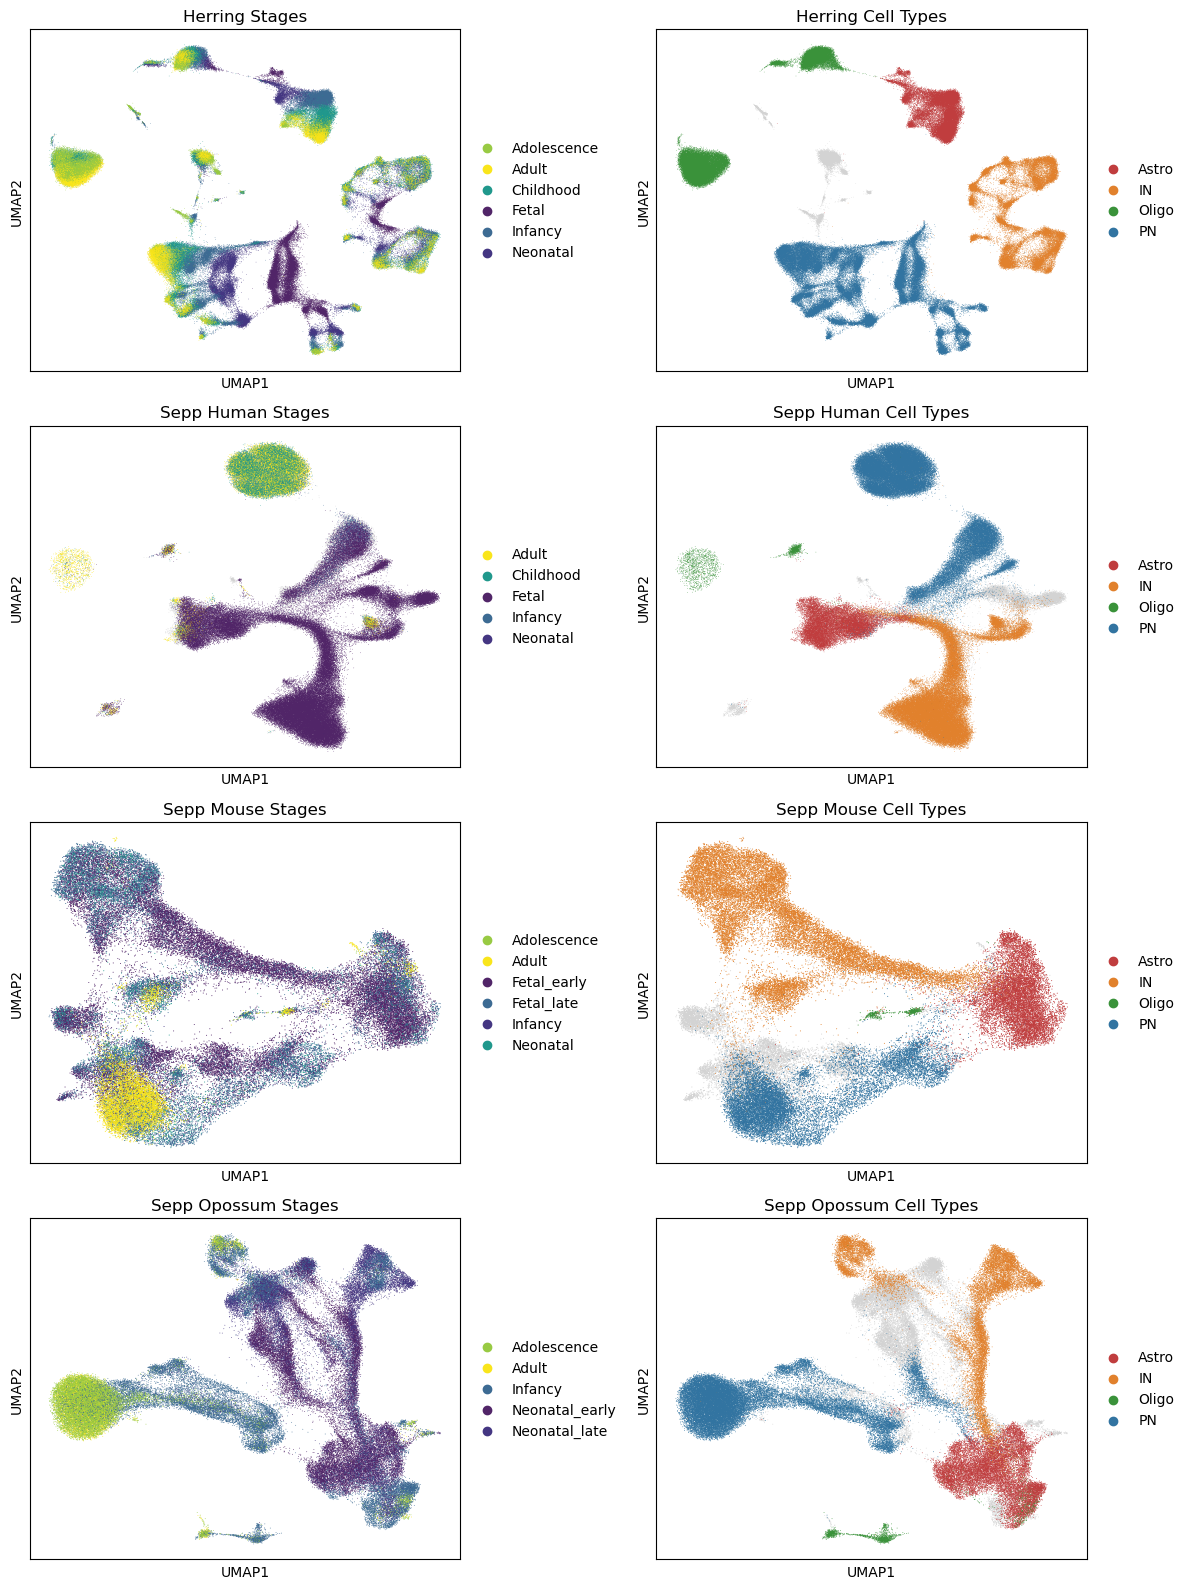

In [54]:
colours = [(0.19460784313725488, 0.45343137254901944, 0.632843137254902, 1),
            (0.8818627450980391, 0.5053921568627451, 0.17303921568627467, 1),
            (0.22941176470588232, 0.5705882352941177, 0.22941176470588232, 1),
            (0.7534313725490196, 0.23872549019607847, 0.24166666666666664, 1)]
cell_type_colours = {t:c for t,c in zip(['PN', 'IN', 'Oligo', 'Astro'],colours)}
cell_type_colours['Non-Neu'] = 'lightgray'
cell_type_colours['Poor-Quality'] = 'lightgray'
cell_type_colours['Vas'] = 'lightgray'
cell_type_colours['None'] = 'lightgray'
nrows = 4
ncols = 2
figsize = 4
fig, axs = plt.subplots(nrows = nrows, ncols = ncols, 
                        figsize=(ncols * figsize + figsize * (ncols-1), nrows * figsize))
cell_types = ['PN', 'IN', 'Oligo', 'Astro']
sc.pl.umap(herring, color='stage_id', na_in_legend=False, 
           title='Herring Stages', ax=axs[0,0], show=False)
sc.pl.umap(herring, color='cell_type', groups=cell_types, na_in_legend=False, 
           title='Herring Cell Types', ax=axs[0,1], show=False, palette=cell_type_colours)
sc.pl.umap(sepp_human, color='stage_id', groups=['Adult', 'Childhood', 'Fetal', 'Infancy', 'Neonatal'], na_in_legend=False, 
           title='Sepp Human Stages', ax=axs[1,0], show=False, palette={'Adult': '#F9E51B',
 'Childhood': '#20988C',
 'Fetal': '#512568',
 'Infancy': '#3D6B93',
 'Neonatal': '#443682',
 'None': 'lightgray'})
sc.pl.umap(sepp_human, color='broad_cell_type', groups=cell_types, na_in_legend=False, 
           title='Sepp Human Cell Types', ax=axs[1,1], show=False, palette=cell_type_colours)
sc.pl.umap(sepp_mouse, color='stage_id', groups=set(sepp_mouse.obs['stage_id'].values.tolist()), na_in_legend=False, 
           title='Sepp Mouse Stages', ax=axs[2,0], show=False, palette={'Adolescence': '#98CA43',
 'Adult': '#F9E51B',
 'Neonatal': '#20988C',
 'Fetal_early': '#512568',
 'Fetal_late': '#3D6B93',
 'Infancy': '#443682',
 'Childhood': 'lightgray',
 'Fetal': 'lightgray'})
sc.pl.umap(sepp_mouse, color='broad_cell_type', groups=cell_types, na_in_legend=False, 
           title='Sepp Mouse Cell Types', ax=axs[2,1], show=False, palette=cell_type_colours)
sc.pl.umap(sepp_opossum, color='stage_id', groups=set(sepp_opossum.obs['stage_id'].values.tolist()), na_in_legend=False, 
           title='Sepp Opossum Stages', ax=axs[3,0], show=False, palette={'Adolescence': '#98CA43',
 'Adult': '#F9E51B',
 'Neonatal_early': '#512568',
 'Infancy': '#3D6B93',
 'Neonatal_late': '#443682',
 'Childhood': 'lightgray',
 'Fetal': 'lightgray',
 'Neonatal': 'lightgray'})
sc.pl.umap(sepp_opossum, color='broad_cell_type', groups=cell_types, na_in_legend=False, 
           title='Sepp Opossum Cell Types', ax=axs[3,1], show=False, palette=cell_type_colours)
plt.tight_layout()
plt.savefig(str(FIG_PATH+'umap_summary.png'), dpi=300, bbox_inches='tight')
plt.show()